In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import nice
from nice.reload import deep_reload

<BarContainer object of 21 artists>

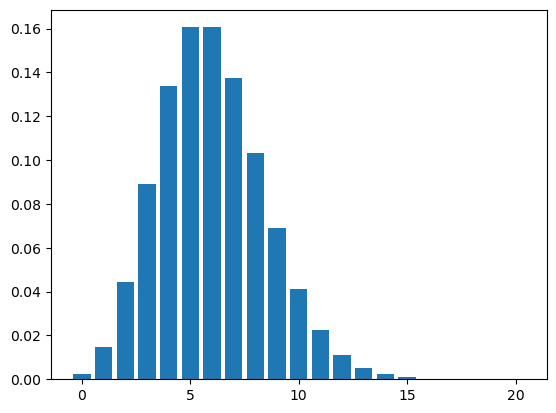

In [118]:
from scipy.stats import rv_histogram, norm, uniform, expon, triang, poisson

mu = 6

dist = poisson(mu)
x = list(range(21))

plt.bar(x, dist.pmf(x))

In [133]:
df = pd.read_csv('../teslascope_analysis/charges_summary_anonymized.csv')
df = df[~np.isnan(df['charge_energy_calculated'])]
df_dc = df[df['fast_charger_present'] == True]
df_dc = df_dc[df_dc['battery_level_start'] <= 85]

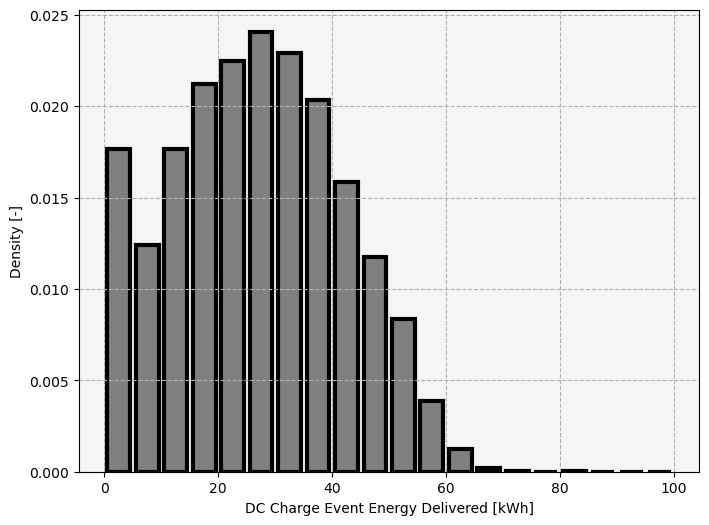

In [134]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

kw = {
    'bins': np.linspace(0, 100, 21),
    'density': True,
    'rwidth': .8,
    'lw': 3,
    'fc': 'gray',
    'ec': 'k',
}

_ = ax.hist(df_dc['charge_energy_added'], **kw)

kw = {
    'facecolor': 'whitesmoke',
    'xlabel': 'DC Charge Event Energy Delivered [kWh]',
    'ylabel': 'Density [-]',
}

ax.set(**kw)

kw = {
    'ls': '--',
}

ax.grid(**kw)

# fig.savefig('charge_energy.png', bbox_inches = 'tight', dpi = 300)

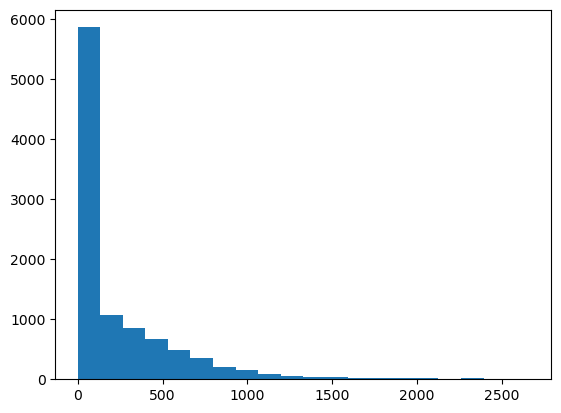

In [173]:
deep_reload(nice)

n = 10000

power = 80e3
energy = df_dc['charge_energy_added'].to_numpy() * 3.6e6
c = 5

rho = .9

mean_service_time = energy.mean() / power
mean_inter_arrival_time = 1 / (rho * (1 / mean_service_time) * c)
mean_inter_arrival_time

l = poisson(mean_inter_arrival_time)


duration = energy / power
m = rv_histogram(np.histogram(duration, bins = 100))

a, s, f = nice.queue.mmc_sim(l, m, c, n)

_ = plt.hist(s - a, bins = 20)

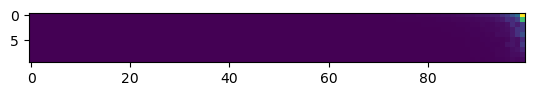

In [184]:
deep_reload(nice)

n = 10000

power = 80e3
energy = df_dc['charge_energy_added'].to_numpy() * 3.6e6
duration = energy / power
m = rv_histogram(np.histogram(duration, bins = 100))

c = list(range(1, 11))
rho = np.linspace(.01, 1, 100)

z = np.zeros((len(c), len(rho)))

for i, ci in enumerate(c):
    for j, rhoj in enumerate(rho):

        # print(ci, rhoj)

        mean_service_time = energy.mean() / power
        mean_inter_arrival_time = 1 / (rhoj * (1 / mean_service_time) * ci)
        mean_inter_arrival_time
        
        l = poisson(mean_inter_arrival_time)
        
        a, s, f = nice.queue.mmc_sim(l, m, ci, n)

        z[i, j] = (s - a).mean()

fig, ax = plt.subplots()

ax.imshow(z)

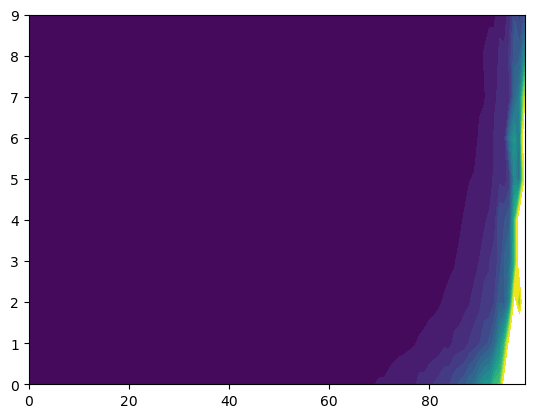

In [188]:
fig, ax = plt.subplots()

_ = plt.contourf(z, levels = np.linspace(0, 3600, 21))

In [150]:
energy = df_dc['charge_energy_added'].to_numpy()
duration = energy / 80 * 60
duration

array([39.96  , 37.1325, 40.035 , ..., 30.615 , 15.315 , 28.2375])

In [167]:
l.rvs(size = 10), m.rvs(size = 10)

(array([490, 497, 476, 482, 497, 479, 512, 506, 513, 540]),
 array([ 606.23480514, 1797.82284098, 1377.04202274, 1263.88234712,
        1059.86265544,  852.86403084, 1237.63387381,  313.75843065,
        1678.55663577, 1357.47130621]))

In [58]:

from heapq import heappush, heappop

a = np.cumsum(l.rvs(5))
h = []

for a in a:

    heappush(h, a)

for idx in range(6):

    o = heappop(h)

IndexError: index out of range

In [88]:
import random
import math 
import copy
import numpy as np
import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt

from argparse import Namespace

args = Namespace
args.simT = 10000
args.arrR = 10
args.serR = 3
args.k = 6



arrivalList = []
serviceList = []
startList = []
departureList = []
serverList = [] 
# record the departure times of servers that are busy

# generate arrival time list (indepedent)
arrivalTime = 0
while arrivalTime < args.simT:
    arrivalTime += random.expovariate(args.arrR)
    arrivalList.append(arrivalTime)

'''
Show ArrivalList
'''
printArrivalList = [round(a, 3) for a in arrivalList]
# print(printArrivalList)
aList = copy.copy(arrivalList)

# run simulation
currentTime = 0
while currentTime < args.simT:

    currentTime = aList[0] # time stamp for reference

    if len(serverList) < args.k:
        startTime = aList[0]
    else: 
        startTime = serverList[serverList.index(min(serverList))]
        del(serverList[serverList.index(min(serverList))])
    
    startList.append(startTime)
    
    serviceTime = random.expovariate(args.serR)
    serviceList.append(serviceTime)

    departureTime = startTime + serviceTime

    departureList.append(departureTime)
    serverList.append(departureTime)
    aList.pop(0)

    if len(aList) == 0: break

    while len(serverList) > 0:
        if serverList[serverList.index(min(serverList))] < aList[0]:
            del(serverList[serverList.index(min(serverList))])
        else: break
    
'''
Performance Measure
'''
waitList = [startList[i] - arrivalList[i] for i in range(len(startList))]
# waitList

fig, ax = plt.subplots()

_ = ax.hist(waitList)
plt.show()